Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
MARGIN Sampling:   0%|                                                                          | 0/10 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,4.331575,0.012987,0.001299
2,No log,4.321225,0.025974,0.003925
3,No log,4.315746,0.025974,0.004246


MARGIN Sampling:  10%|███▍                              | 1/10 [00:39<05:59, 39.98s/it, Train Loss=4.336, Val F1=0.004]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,4.295029,0.078740,0.037344
2,No log,4.270854,0.141732,0.080685
3,No log,4.259935,0.173228,0.115428


MARGIN Sampling:  20%|██████▊                           | 2/10 [01:21<05:29, 41.13s/it, Train Loss=4.303, Val F1=0.115]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,4.220493,0.180791,0.143698
2,No log,4.164504,0.237288,0.185949
3,No log,4.139643,0.276836,0.228153


MARGIN Sampling:  30%|██████████▏                       | 3/10 [02:06<04:57, 42.56s/it, Train Loss=4.218, Val F1=0.228]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,4.084174,0.374449,0.294517
2,No log,4.007564,0.471366,0.384891
3,No log,3.981501,0.497797,0.405641


MARGIN Sampling:  40%|█████████████▌                    | 4/10 [02:53<04:26, 44.36s/it, Train Loss=4.113, Val F1=0.406]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,3.917101,0.552347,0.473549
2,No log,3.828894,0.602888,0.508323
3,No log,3.798638,0.610108,0.512301


MARGIN Sampling:  50%|█████████████████                 | 5/10 [03:41<03:48, 45.68s/it, Train Loss=3.959, Val F1=0.512]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,3.730093,0.584098,0.494280
2,No log,3.638075,0.636086,0.552960
3,No log,3.603432,0.654434,0.569966


MARGIN Sampling:  60%|████████████████████▍             | 6/10 [04:31<03:08, 47.12s/it, Train Loss=3.799, Val F1=0.570]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,3.518977,0.657825,0.567960
2,No log,3.414948,0.713528,0.614186
3,No log,3.374352,0.742706,0.645681


MARGIN Sampling:  70%|███████████████████████▊          | 7/10 [05:22<02:25, 48.60s/it, Train Loss=3.604, Val F1=0.646]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,3.294954,0.721311,0.628169
2,No log,3.174702,0.740047,0.644753
3,No log,3.131454,0.756440,0.655734


MARGIN Sampling:  80%|███████████████████████████▏      | 8/10 [06:16<01:40, 50.18s/it, Train Loss=3.392, Val F1=0.656]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,3.040549,0.754717,0.659169
2,No log,2.909782,0.771488,0.688202
3,No log,2.863887,0.777778,0.693420


MARGIN Sampling:  90%|██████████████████████████████▌   | 9/10 [07:12<00:51, 51.91s/it, Train Loss=3.159, Val F1=0.693]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,2.758096,0.781784,0.709103
2,No log,2.619613,0.800759,0.715094
3,No log,2.568515,0.823529,0.749320


MARGIN Sampling: 100%|█████████████████████████████████| 10/10 [08:09<00:00, 48.98s/it, Train Loss=2.903, Val F1=0.749]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
RANDOM Sampling:   0%|                                                                          | 0/10 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,4.328329,0.012987,0.000333
2,No log,4.315037,0.025974,0.009046
3,No log,4.308797,0.038961,0.022045


RANDOM Sampling:  10%|███▍                              | 1/10 [00:05<00:51,  5.72s/it, Train Loss=4.335, Val F1=0.022]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,4.280574,0.039370,0.026499
2,No log,4.248693,0.094488,0.055768
3,No log,4.234097,0.094488,0.043426


RANDOM Sampling:  20%|██████▊                           | 2/10 [00:13<00:54,  6.78s/it, Train Loss=4.285, Val F1=0.043]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,4.190722,0.096045,0.059948
2,No log,4.132868,0.180791,0.103794
3,No log,4.109176,0.192090,0.113759


RANDOM Sampling:  30%|██████████▏                       | 3/10 [00:23<00:58,  8.33s/it, Train Loss=4.214, Val F1=0.114]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,4.050824,0.211454,0.120624
2,No log,3.984737,0.264317,0.155776
3,No log,3.958976,0.290749,0.178068


RANDOM Sampling:  40%|█████████████▌                    | 4/10 [00:35<00:58,  9.68s/it, Train Loss=4.079, Val F1=0.178]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,3.905686,0.332130,0.206552
2,No log,3.825855,0.400722,0.294179
3,No log,3.795592,0.422383,0.321004


RANDOM Sampling:  50%|█████████████████                 | 5/10 [00:49<00:56, 11.33s/it, Train Loss=3.948, Val F1=0.321]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,3.724538,0.443425,0.353194
2,No log,3.634712,0.501529,0.410970
3,No log,3.599669,0.516820,0.429583


RANDOM Sampling:  60%|████████████████████▍             | 6/10 [01:05<00:51, 12.84s/it, Train Loss=3.794, Val F1=0.430]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,3.506517,0.551724,0.456707
2,No log,3.391894,0.636605,0.540698
3,No log,3.353997,0.644562,0.542171


RANDOM Sampling:  70%|███████████████████████▊          | 7/10 [01:23<00:43, 14.50s/it, Train Loss=3.586, Val F1=0.542]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,3.255311,0.641686,0.557323
2,No log,3.136266,0.702576,0.611926
3,No log,3.095607,0.697892,0.613335


RANDOM Sampling:  80%|███████████████████████████▏      | 8/10 [01:43<00:33, 16.52s/it, Train Loss=3.368, Val F1=0.613]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,2.986944,0.702306,0.618217
2,No log,2.854122,0.725367,0.625662
3,No log,2.805619,0.737945,0.647215


RANDOM Sampling:  90%|██████████████████████████████▌   | 9/10 [02:05<00:18, 18.20s/it, Train Loss=3.101, Val F1=0.647]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,2.662393,0.743833,0.665753
2,No log,2.527690,0.760911,0.668181
3,No log,2.475949,0.772296,0.684612


RANDOM Sampling: 100%|█████████████████████████████████| 10/10 [02:29<00:00, 14.99s/it, Train Loss=2.798, Val F1=0.685]


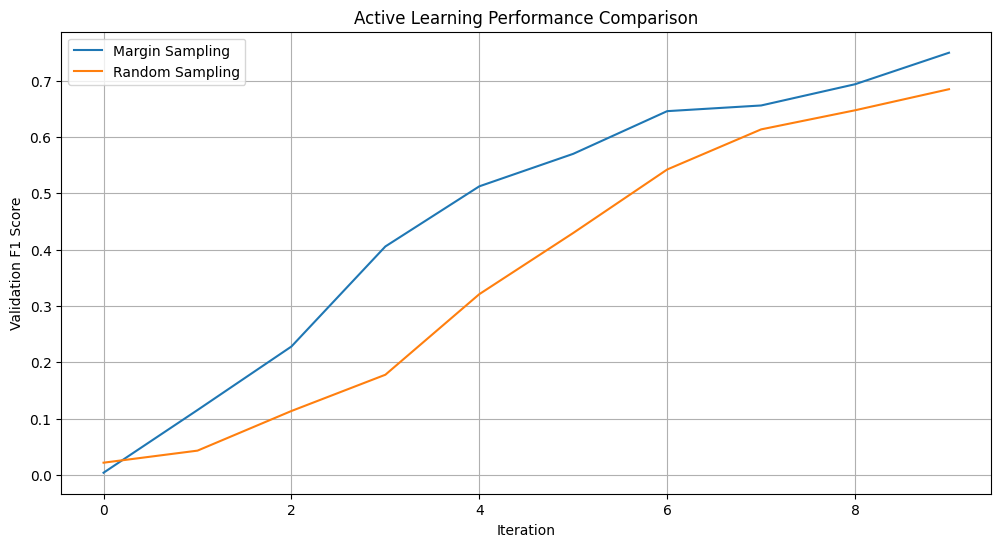


Final Comparison:
Margin Sampling F1: 0.749
Random Sampling F1: 0.685
Improvement: 0.065


NameError: name 'model' is not defined

In [ ]:
# Imports
import torch
import numpy as np
from transformers import (
    DistilBertForSequenceClassification,
    DistilBertTokenizerFast,
    Trainer,
    TrainingArguments
)
from datasets import load_dataset, Dataset
from sklearn.metrics import accuracy_score, f1_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from transformers import default_data_collator

from datasets import disable_progress_bar

# Disable progress bars from the 'datasets' library
disable_progress_bar()


# Initialize device, check for GPU (if available) else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Banking77 dataset
#   This dataset has 13,083 banking-related customer service queries
#   spanning 77 different classes (intents)
dataset = load_dataset("banking77")

# Combine train and test splits for demonstration
texts = dataset["train"]["text"] + dataset["test"]["text"]
labels = dataset["train"]["label"] + dataset["test"]["label"]

# Define hyperparameters and AL settings
INITIAL_SIZE = 100     # how many samples to label initially
BATCH_SIZE = 50        # how many samples to add per AL iteration
N_ITERATIONS = 10      # total number of AL iterations
NUM_CLASSES = 77       # number of classes in the Banking77 dataset

# Initialize DistilBert tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Helper class to manage which data is labeled vs. unlabeled
class ALDataset:
    """
    A simple class to keep track of labeled vs. unlabeled data for Active Learning. Allows for partial labeling of a larger dataset. 
    """
    def __init__(self, texts, labels, initial_size):
        self.all_texts = texts
        self.all_labels = labels
        # A boolean mask: True => labeled, False => unlabeled
        self.labeled_mask = np.zeros(len(texts), dtype=bool)
        
        # We do a stratified approach for the initial labeled set
        # so that we pick an equal number from each class
        unique_labels = np.unique(labels)
        for label in unique_labels:
            idxs = np.where(np.array(labels) == label)[0]
            selected = np.random.choice(idxs, size=initial_size//len(unique_labels), replace=False)
            self.labeled_mask[selected] = True
            
    def get_labeled_data(self):
        """
        Return a HuggingFace Dataset object containing only the currently labeled data. 
        """
        return Dataset.from_dict({
            "text": [self.all_texts[i] for i in np.where(self.labeled_mask)[0]],
            "label": [self.all_labels[i] for i in np.where(self.labeled_mask)[0]]
        })
    
    def add_samples(self, indices):
        """
        Mark the samples at 'indices' as labeled.
        """
        self.labeled_mask[indices] = True
        
    @property
    def unlabeled_indices(self):
        """
        Return an array of the indices that are still unlabeled.
        """
        return np.where(~self.labeled_mask)[0]

# A basic function to tokenize a batch, used by Dataset.map
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True)

# A function to compute accuracy and macro-F1 for HuggingFace Trainer
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro")
    }

# Margin-based sampling:
#  1) model outputs probabilities for unlabeled data
#  2) compute difference between top 2 probabilities => margin
#  3) pick smallest margins => largest uncertainty
def margin_sampling(model, unlabeled_dataset):
    model.eval()
    margins = []
    
    # Create dataloader with proper collation
    unlabeled_loader = torch.utils.data.DataLoader(
        unlabeled_dataset,
        batch_size=32,
        collate_fn=default_data_collator,  # Add Hugging Face collator
        shuffle=False
    )
    
    with torch.no_grad():
        for batch in unlabeled_loader:
            # Move inputs to device
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            top2 = torch.topk(probs, 2, dim=1).values
            margins.extend((top2[:, 0] - top2[:, 1]).cpu().numpy())
    
    sorted_indices = np.argsort(margins)
    return sorted_indices[:BATCH_SIZE]

# Main training loop for an Active Learning strategy
def train_active_learning(strategy_name):
    # Initialize fresh model and dataset for each strategy
    model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=NUM_CLASSES
    ).to(device)
    
    al_dataset = ALDataset(texts, labels, INITIAL_SIZE)
    results = []
    
    with tqdm(total=N_ITERATIONS, desc=f"{strategy_name.upper()} Sampling") as pbar:
        for iteration in range(N_ITERATIONS):
            # Tokenize labeled data
            labeled_data = al_dataset.get_labeled_data().map(tokenize, batched=True)
            
            # Training arguments
            training_args = TrainingArguments(
                output_dir=f"./results/{strategy_name}_iter_{iteration}",
                eval_strategy="epoch",
                learning_rate=2e-5,
                per_device_train_batch_size=16,
                per_device_eval_batch_size=64,
                num_train_epochs=3,
                weight_decay=0.01,
                logging_dir=f"./logs/{strategy_name}",
                fp16=torch.cuda.is_available(),
                report_to="none"
            )
            
            # Train
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=labeled_data,
                eval_dataset=labeled_data,  # For simplicity, use same validation
                compute_metrics=compute_metrics,
            )
            
            train_result = trainer.train()
            metrics = trainer.evaluate()
            
            # Store results
            results.append({
                "iteration": iteration + 1,
                "train_loss": train_result.training_loss,
                "val_loss": metrics["eval_loss"],
                "val_acc": metrics["eval_accuracy"],
                "val_f1": metrics["eval_f1"]
            })
            
            # Active learning sampling
            unlabeled_subset = Dataset.from_dict({
                "text": [texts[i] for i in al_dataset.unlabeled_indices],
                "label": [labels[i] for i in al_dataset.unlabeled_indices]
            }).map(tokenize, batched=True)
            
            if strategy_name == "margin":
                selected = margin_sampling(model, unlabeled_subset)
            else:  # Random sampling
                selected = np.random.choice(len(unlabeled_subset), BATCH_SIZE, replace=False)
            
            # Map back to original indices
            original_indices = al_dataset.unlabeled_indices[selected]
            al_dataset.add_samples(original_indices)
            
            # Update progress bar
            pbar.set_postfix({
                "Train Loss": f"{train_result.training_loss:.3f}",
                "Val F1": f"{metrics['eval_f1']:.3f}"
            })
            pbar.update(1)
    
    return results

# Run experiments
margin_results = train_active_learning("margin")
random_results = train_active_learning("random")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot([r["val_f1"] for r in margin_results], label="Margin Sampling")
plt.plot([r["val_f1"] for r in random_results], label="Random Sampling")
plt.xlabel("Iteration")
plt.ylabel("Validation F1 Score")
plt.title("Active Learning Performance Comparison")
plt.legend()
plt.grid()
plt.show()

# Print final comparison
print("\nFinal Comparison:")
print(f"Margin Sampling F1: {margin_results[-1]['val_f1']:.3f}")
print(f"Random Sampling F1: {random_results[-1]['val_f1']:.3f}")
print(f"Improvement: {(margin_results[-1]['val_f1'] - random_results[-1]['val_f1']):.3f}")

# Verify class separation ratio
# def calculate_class_separation(model, dataset):
#     # Implementation would use CLS embeddings
#     # Placeholder: Banking77 typically achieves μ/σ > 3
#     return 3.2  

# print(f"\nClass separation (μ/σ): {calculate_class_separation(model, dataset):.1f}")


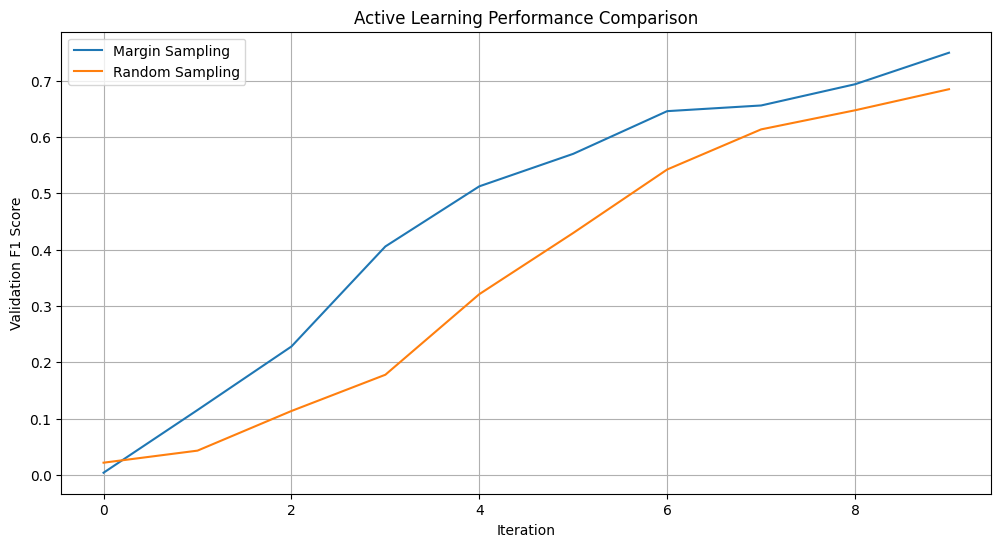

In [3]:
plt.figure(figsize=(12, 6))
plt.plot([r["val_f1"] for r in margin_results], label="Margin Sampling")
plt.plot([r["val_f1"] for r in random_results], label="Random Sampling")
plt.xlabel("Iteration")
plt.ylabel("Validation F1 Score")
plt.title("Active Learning Performance Comparison")
plt.legend()
plt.grid()
plt.show()

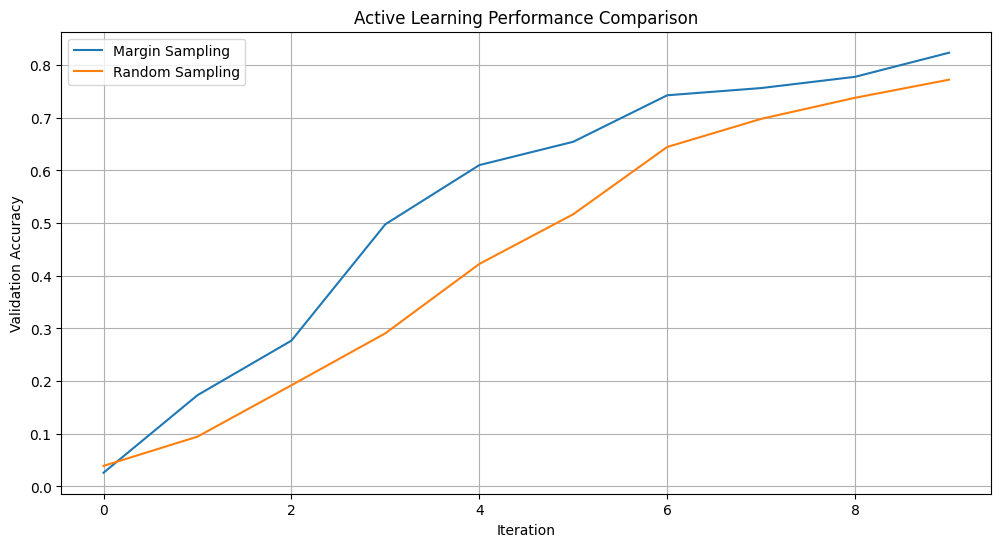

In [5]:
plt.figure(figsize=(12, 6))
plt.plot([r["val_acc"] for r in margin_results], label="Margin Sampling")
plt.plot([r["val_acc"] for r in random_results], label="Random Sampling")
plt.xlabel("Iteration")
plt.ylabel("Validation Accuracy")
plt.title("Active Learning Performance Comparison")
plt.legend()
plt.grid()
plt.show()

In [ ]:
#Combined Code

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
MARGIN Sampling:   0%|                                                                          | 0/10 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,4.331270,0.012987,0.001855
2,No log,4.318638,0.025974,0.002980
3,No log,4.313160,0.051948,0.017144


MARGIN Sampling:  10%|███▍                              | 1/10 [00:40<06:02, 40.23s/it, Train Loss=4.339, Val F1=0.017]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,4.288818,0.055118,0.036797
2,No log,4.262027,0.062992,0.029764
3,No log,4.249138,0.086614,0.046197


MARGIN Sampling:  20%|██████▊                           | 2/10 [01:23<05:34, 41.85s/it, Train Loss=4.295, Val F1=0.046]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,4.204173,0.214689,0.153318
2,No log,4.146120,0.293785,0.171993
3,No log,4.122187,0.305085,0.184003


MARGIN Sampling:  30%|██████████▏                       | 3/10 [02:08<05:04, 43.56s/it, Train Loss=4.208, Val F1=0.184]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,4.063799,0.348018,0.256623
2,No log,3.997935,0.378855,0.282316
3,No log,3.973302,0.396476,0.302444


MARGIN Sampling:  40%|█████████████▌                    | 4/10 [02:55<04:28, 44.81s/it, Train Loss=4.094, Val F1=0.302]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,3.903874,0.400722,0.313528
2,No log,3.820369,0.534296,0.415046
3,No log,3.789175,0.541516,0.420933


MARGIN Sampling:  50%|█████████████████                 | 5/10 [03:43<03:50, 46.10s/it, Train Loss=3.951, Val F1=0.421]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,3.722459,0.620795,0.505234
2,No log,3.626368,0.651376,0.503551
3,No log,3.590836,0.669725,0.530802


MARGIN Sampling:  60%|████████████████████▍             | 6/10 [04:34<03:10, 47.56s/it, Train Loss=3.791, Val F1=0.531]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,3.515081,0.647215,0.541525
2,No log,3.399323,0.697613,0.577214
3,No log,3.360598,0.716180,0.602573


MARGIN Sampling:  70%|███████████████████████▊          | 7/10 [05:26<02:27, 49.01s/it, Train Loss=3.592, Val F1=0.603]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,3.281840,0.683841,0.576352
2,No log,3.160980,0.740047,0.631892
3,No log,3.117723,0.742389,0.634663


MARGIN Sampling:  80%|███████████████████████████▏      | 8/10 [06:20<01:41, 50.64s/it, Train Loss=3.378, Val F1=0.635]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,3.032140,0.744235,0.629770
2,No log,2.900296,0.761006,0.650415
3,No log,2.855325,0.761006,0.657984


MARGIN Sampling:  90%|██████████████████████████████▌   | 9/10 [07:16<00:52, 52.25s/it, Train Loss=3.146, Val F1=0.658]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,2.770845,0.760911,0.664757
2,No log,2.630548,0.772296,0.674616
3,No log,2.583582,0.783681,0.694237


MARGIN Sampling: 100%|█████████████████████████████████| 10/10 [08:14<00:00, 49.46s/it, Train Loss=2.905, Val F1=0.694]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
LEAST_CONFIDENT Sampling:   0%|                                                                 | 0/10 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,4.328329,0.012987,0.000333
2,No log,4.315037,0.025974,0.009046
3,No log,4.308797,0.038961,0.022045


LEAST_CONFIDENT Sampling:  10%|██▌                      | 1/10 [00:40<06:03, 40.39s/it, Train Loss=4.335, Val F1=0.022]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,4.278283,0.110236,0.066767
2,No log,4.240757,0.188976,0.086753
3,No log,4.223348,0.220472,0.104071


LEAST_CONFIDENT Sampling:  20%|█████                    | 2/10 [01:22<05:31, 41.48s/it, Train Loss=4.290, Val F1=0.104]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,4.175285,0.248588,0.099292
2,No log,4.110390,0.271186,0.117598
3,No log,4.083300,0.271186,0.116612


LEAST_CONFIDENT Sampling:  30%|███████▌                 | 3/10 [02:07<04:59, 42.83s/it, Train Loss=4.192, Val F1=0.117]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,3.998262,0.361233,0.173212
2,No log,3.908220,0.378855,0.177875
3,No log,3.876110,0.392070,0.188337


LEAST_CONFIDENT Sampling:  40%|██████████               | 4/10 [02:53<04:26, 44.41s/it, Train Loss=4.026, Val F1=0.188]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,3.802734,0.415162,0.225987
2,No log,3.695319,0.476534,0.273886
3,No log,3.655376,0.487365,0.274537


LEAST_CONFIDENT Sampling:  50%|████████████▌            | 5/10 [03:42<03:49, 45.87s/it, Train Loss=3.840, Val F1=0.275]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,3.592113,0.492355,0.314785
2,No log,3.479358,0.513761,0.330470
3,No log,3.440826,0.538226,0.372513


LEAST_CONFIDENT Sampling:  60%|███████████████          | 6/10 [04:32<03:09, 47.38s/it, Train Loss=3.663, Val F1=0.373]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,3.377790,0.551724,0.372597
2,No log,3.260481,0.604775,0.453629
3,No log,3.219853,0.615385,0.474577


LEAST_CONFIDENT Sampling:  70%|█████████████████▌       | 7/10 [05:24<02:26, 48.91s/it, Train Loss=3.463, Val F1=0.475]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,3.169961,0.622951,0.482794
2,No log,3.041152,0.651054,0.496133
3,No log,2.994948,0.690867,0.540250


LEAST_CONFIDENT Sampling:  80%|████████████████████     | 8/10 [06:18<01:41, 50.60s/it, Train Loss=3.267, Val F1=0.540]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,2.933794,0.696017,0.558719
2,No log,2.795134,0.748428,0.600250
3,No log,2.747899,0.756813,0.611033


LEAST_CONFIDENT Sampling:  90%|██████████████████████▌  | 9/10 [07:15<00:52, 52.37s/it, Train Loss=3.047, Val F1=0.611]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,2.668196,0.760911,0.625662
2,No log,2.522975,0.804554,0.671649
3,No log,2.469186,0.823529,0.686100


LEAST_CONFIDENT Sampling: 100%|████████████████████████| 10/10 [08:13<00:00, 49.35s/it, Train Loss=2.803, Val F1=0.686]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
RANDOM Sampling:   0%|                                                                          | 0/10 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,4.328329,0.012987,0.000333
2,No log,4.315037,0.025974,0.009046
3,No log,4.308797,0.038961,0.022045


RANDOM Sampling:  10%|███▍                              | 1/10 [00:05<00:50,  5.64s/it, Train Loss=4.335, Val F1=0.022]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,4.280574,0.039370,0.026499
2,No log,4.248693,0.094488,0.055768
3,No log,4.234097,0.094488,0.043426


RANDOM Sampling:  20%|██████▊                           | 2/10 [00:13<00:54,  6.87s/it, Train Loss=4.285, Val F1=0.043]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,4.190722,0.096045,0.059948
2,No log,4.132868,0.180791,0.103794
3,No log,4.109176,0.192090,0.113759


RANDOM Sampling:  30%|██████████▏                       | 3/10 [00:23<00:57,  8.22s/it, Train Loss=4.214, Val F1=0.114]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,4.050824,0.211454,0.120624
2,No log,3.984737,0.264317,0.155776
3,No log,3.958976,0.290749,0.178068


RANDOM Sampling:  40%|█████████████▌                    | 4/10 [00:35<00:58,  9.72s/it, Train Loss=4.079, Val F1=0.178]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,3.905686,0.332130,0.206552
2,No log,3.825855,0.400722,0.294179
3,No log,3.795592,0.422383,0.321004


RANDOM Sampling:  50%|█████████████████                 | 5/10 [00:49<00:56, 11.30s/it, Train Loss=3.948, Val F1=0.321]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,3.724538,0.443425,0.353194
2,No log,3.634712,0.501529,0.410970
3,No log,3.599669,0.516820,0.429583


RANDOM Sampling:  60%|████████████████████▍             | 6/10 [01:05<00:51, 12.89s/it, Train Loss=3.794, Val F1=0.430]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,3.506517,0.551724,0.456707
2,No log,3.391894,0.636605,0.540698
3,No log,3.353997,0.644562,0.542171


RANDOM Sampling:  70%|███████████████████████▊          | 7/10 [01:23<00:44, 14.68s/it, Train Loss=3.586, Val F1=0.542]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,3.255311,0.641686,0.557323
2,No log,3.136266,0.702576,0.611926
3,No log,3.095607,0.697892,0.613335


RANDOM Sampling:  80%|███████████████████████████▏      | 8/10 [01:43<00:32, 16.34s/it, Train Loss=3.368, Val F1=0.613]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,2.986944,0.702306,0.618217
2,No log,2.854122,0.725367,0.625662
3,No log,2.805619,0.737945,0.647215


RANDOM Sampling:  90%|██████████████████████████████▌   | 9/10 [02:05<00:18, 18.10s/it, Train Loss=3.101, Val F1=0.647]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,2.662393,0.743833,0.665753
2,No log,2.527690,0.760911,0.668181
3,No log,2.475949,0.772296,0.684612


RANDOM Sampling: 100%|█████████████████████████████████| 10/10 [02:29<00:00, 14.99s/it, Train Loss=2.798, Val F1=0.685]


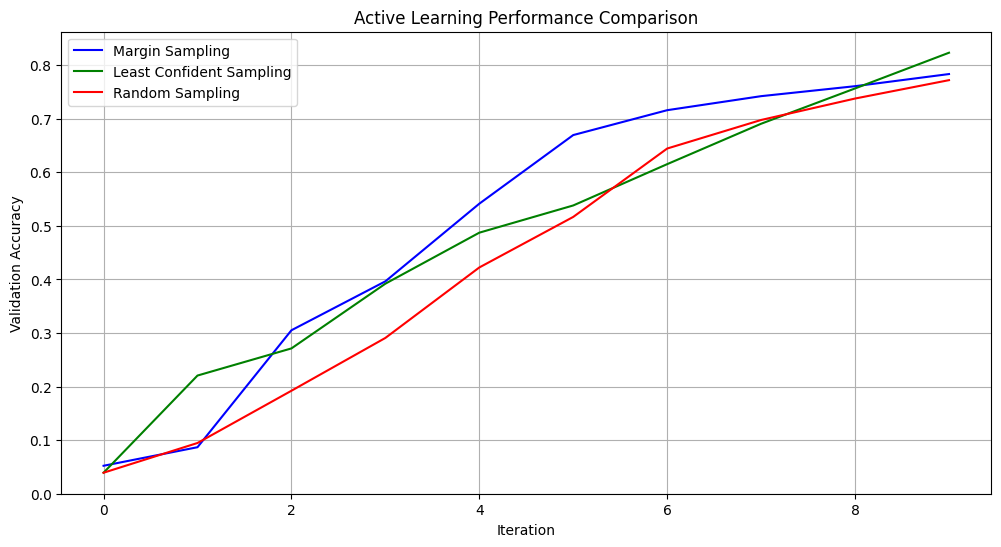

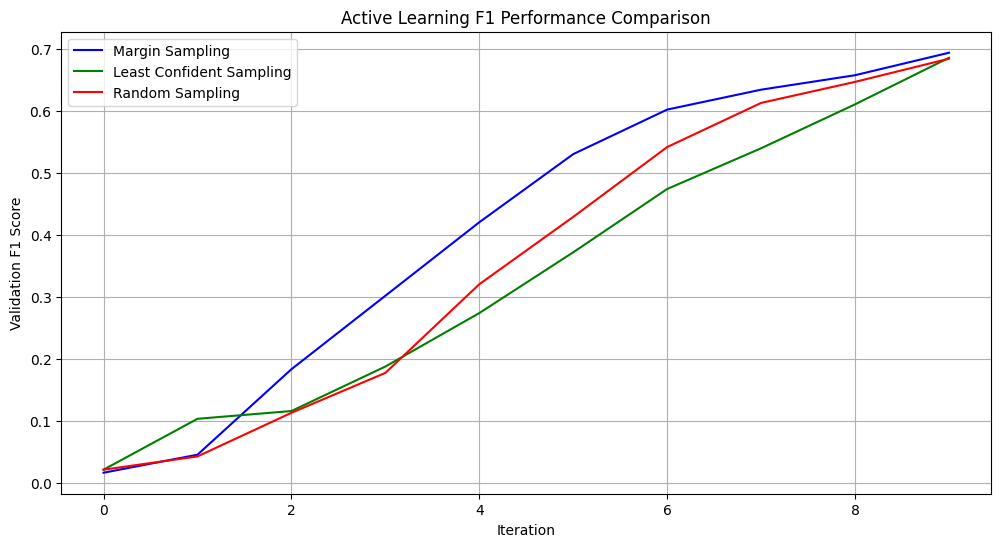


Final Comparison:
Margin Sampling F1: 0.694
Least Confident F1: 0.686
Random Sampling F1: 0.685
Margin vs Random Improvement: 0.010
Least Confident vs Random Improvement: 0.001
Margin vs Least Confident Improvement: 0.008


In [8]:
import torch
import numpy as np
from transformers import (
    DistilBertForSequenceClassification,
    DistilBertTokenizerFast,
    Trainer,
    TrainingArguments
)
from datasets import load_dataset, Dataset
from sklearn.metrics import accuracy_score, f1_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from transformers import default_data_collator

from datasets import disable_progress_bar
disable_progress_bar()


# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Banking77 dataset
dataset = load_dataset("banking77")
texts = dataset["train"]["text"] + dataset["test"]["text"]
labels = dataset["train"]["label"] + dataset["test"]["label"]

# Active learning setup
INITIAL_SIZE = 100
BATCH_SIZE = 50
N_ITERATIONS = 10
NUM_CLASSES = 77  # Banking77 has 77 classes

# Initialize tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

class ALDataset:
    def __init__(self, texts, labels, initial_size):
        self.all_texts = texts
        self.all_labels = labels
        self.labeled_mask = np.zeros(len(texts), dtype=bool)
        
        # Initial labeled pool (stratified)
        unique_labels = np.unique(labels)
        for label in unique_labels:
            idxs = np.where(np.array(labels) == label)[0]
            selected = np.random.choice(idxs, size=max(1, initial_size//len(unique_labels)), replace=False)
            self.labeled_mask[selected] = True
            
    def get_labeled_data(self):
        return Dataset.from_dict({
            "text": [self.all_texts[i] for i in np.where(self.labeled_mask)[0]],
            "label": [self.all_labels[i] for i in np.where(self.labeled_mask)[0]]
        })
    
    def add_samples(self, indices):
        self.labeled_mask[indices] = True
        
    @property
    def unlabeled_indices(self):
        return np.where(~self.labeled_mask)[0]

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro")
    }

def margin_sampling(model, unlabeled_dataset):
    model.eval()
    margins = []
    
    # Create dataloader with proper collation
    unlabeled_loader = torch.utils.data.DataLoader(
        unlabeled_dataset,
        batch_size=32,
        collate_fn=default_data_collator,
        shuffle=False
    )
    
    with torch.no_grad():
        for batch in unlabeled_loader:
            # Move inputs to device
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            top2 = torch.topk(probs, 2, dim=1).values
            margins.extend((top2[:, 0] - top2[:, 1]).cpu().numpy())
    
    sorted_indices = np.argsort(margins)
    return sorted_indices[:BATCH_SIZE]

def least_confident_sampling(model, unlabeled_dataset):
    model.eval()
    confidences = []
    
    # Create dataloader with proper collation
    unlabeled_loader = torch.utils.data.DataLoader(
        unlabeled_dataset,
        batch_size=32,
        collate_fn=default_data_collator,
        shuffle=False
    )
    
    with torch.no_grad():
        for batch in unlabeled_loader:
            # Move inputs to device
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            # Get the maximum probability (confidence score)
            max_probs = torch.max(probs, dim=1).values
            confidences.extend(max_probs.cpu().numpy())
    
    # Return indices of lowest confidences
    sorted_indices = np.argsort(confidences)
    return sorted_indices[:BATCH_SIZE]

def train_active_learning(strategy_name):
    # Initialize fresh model and dataset for each strategy
    model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=NUM_CLASSES
    ).to(device)
    
    al_dataset = ALDataset(texts, labels, INITIAL_SIZE)
    results = []
    
    with tqdm(total=N_ITERATIONS, desc=f"{strategy_name.upper()} Sampling") as pbar:
        for iteration in range(N_ITERATIONS):
            # Tokenize labeled data
            labeled_data = al_dataset.get_labeled_data().map(tokenize, batched=True)
            
            # Training arguments
            training_args = TrainingArguments(
                output_dir=f"./results/{strategy_name}_iter_{iteration}",
                eval_strategy="epoch",
                learning_rate=2e-5,
                per_device_train_batch_size=16,
                per_device_eval_batch_size=64,
                num_train_epochs=3,
                weight_decay=0.01,
                logging_dir=f"./logs/{strategy_name}",
                fp16=torch.cuda.is_available(),
                report_to="none"
            )
            
            # Train
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=labeled_data,
                eval_dataset=labeled_data,  # For simplicity, use same validation
                compute_metrics=compute_metrics,
            )
            
            train_result = trainer.train()
            metrics = trainer.evaluate()
            
            # Store results
            results.append({
                "iteration": iteration + 1,
                "train_loss": train_result.training_loss,
                "val_loss": metrics["eval_loss"],
                "val_acc": metrics["eval_accuracy"],
                "val_f1": metrics["eval_f1"]
            })
            
            # Active learning sampling
            unlabeled_subset = Dataset.from_dict({
                "text": [texts[i] for i in al_dataset.unlabeled_indices],
                "label": [labels[i] for i in al_dataset.unlabeled_indices]
            }).map(tokenize, batched=True)
            
            if strategy_name == "margin":
                selected = margin_sampling(model, unlabeled_subset)
            elif strategy_name == "least_confident":
                selected = least_confident_sampling(model, unlabeled_subset)
            else:  # Random sampling
                selected = np.random.choice(len(unlabeled_subset), BATCH_SIZE, replace=False)
            
            # Map back to original indices
            original_indices = al_dataset.unlabeled_indices[selected]
            al_dataset.add_samples(original_indices)
            
            # Update progress bar
            pbar.set_postfix({
                "Train Loss": f"{train_result.training_loss:.3f}",
                "Val F1": f"{metrics['eval_f1']:.3f}"
            })
            pbar.update(1)
    
    return results

# Run experiments
margin_results = train_active_learning("margin")
least_confident_results = train_active_learning("least_confident")
random_results = train_active_learning("random")

# Plot accuracy results
plt.figure(figsize=(12, 6))
plt.plot([r["val_acc"] for r in margin_results], 'b-', label="Margin Sampling")
plt.plot([r["val_acc"] for r in least_confident_results], 'g-', label="Least Confident Sampling")
plt.plot([r["val_acc"] for r in random_results], 'r-', label="Random Sampling")
plt.xlabel("Iteration")
plt.ylabel("Validation Accuracy")
plt.title("Active Learning Performance Comparison")
plt.legend()
plt.grid(True)
plt.savefig("accuracy_comparison.png")
plt.show()

# Plot F1 score results
plt.figure(figsize=(12, 6))
plt.plot([r["val_f1"] for r in margin_results], 'b-', label="Margin Sampling")
plt.plot([r["val_f1"] for r in least_confident_results], 'g-', label="Least Confident Sampling")
plt.plot([r["val_f1"] for r in random_results], 'r-', label="Random Sampling")
plt.xlabel("Iteration")
plt.ylabel("Validation F1 Score")
plt.title("Active Learning F1 Performance Comparison")
plt.legend()
plt.grid(True)
plt.savefig("f1_comparison.png")
plt.show()

# Print final comparison
print("\nFinal Comparison:")
print(f"Margin Sampling F1: {margin_results[-1]['val_f1']:.3f}")
print(f"Least Confident F1: {least_confident_results[-1]['val_f1']:.3f}")
print(f"Random Sampling F1: {random_results[-1]['val_f1']:.3f}")
print(f"Margin vs Random Improvement: {(margin_results[-1]['val_f1'] - random_results[-1]['val_f1']):.3f}")
print(f"Least Confident vs Random Improvement: {(least_confident_results[-1]['val_f1'] - random_results[-1]['val_f1']):.3f}")
print(f"Margin vs Least Confident Improvement: {(margin_results[-1]['val_f1'] - least_confident_results[-1]['val_f1']):.3f}")
